In [26]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import re

In [15]:
# create generators for the training and test sets
np.random.seed(0)
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

data_dir = "data/cinic10"

datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator = datagen.flow_from_directory(
    data_dir + "/train",
    target_size=(32, 32),  # Resize images to this size
    batch_size=20,  # Number of images to load at each iteration
    class_mode="categorical",
)  # Type of classification ('binary' or 'categorical')

test_generator = datagen.flow_from_directory(
    data_dir + "/test",
    target_size=(32, 32),
    batch_size=20,
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [19]:
def generator_to_data(generator, num_samples):
    # Determine the output shape for the data based on the generator properties
    data_shape = (num_samples,) + generator.image_shape
    labels_shape = (
        num_samples,
        generator.num_classes,
    )  # Adjust for one-hot encoded labels

    # Initialize the arrays with the correct shape
    data = np.zeros(data_shape)
    labels = np.zeros(labels_shape)

    # Batch counter
    i = 0
    for inputs_batch, labels_batch in generator:
        batch_size = inputs_batch.shape[
            0
        ]  # Actual batch size may be less than generator.batch_size
        data_index_start = i * generator.batch_size
        data_index_end = data_index_start + batch_size

        # Assign the batch data and labels to the main arrays
        data[data_index_start:data_index_end] = inputs_batch
        labels[data_index_start:data_index_end] = labels_batch

        i += 1  # Increment the batch counter
        if i * generator.batch_size >= num_samples:
            # Break the loop when enough samples have been processed
            break
    # Since labels might be in one-hot encoding (if class_mode='categorical'), convert them back to single digits if necessary
    if generator.class_mode == "categorical":
        labels = np.argmax(labels, axis=1)
    return data, labels

In [20]:
#Generate the data
num_train_samples = 40000
num_test_samples = 1000
# Convert generator data to arrays
training_images, training_labels = generator_to_data(train_generator, num_train_samples)
test_images, test_labels = generator_to_data(test_generator, num_test_samples)



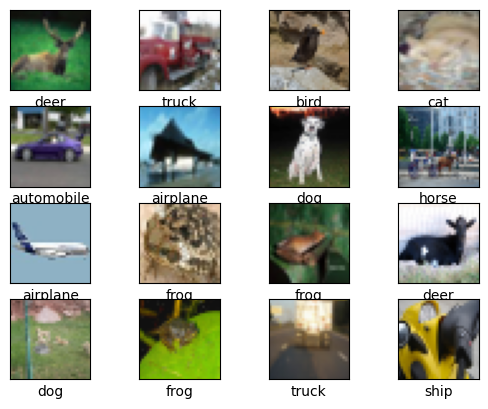

In [21]:
# check if images are properly loaded
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[training_labels[i]])
plt.show()

In [22]:
# create cnn model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))


model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [23]:
# fit model

model.fit(
    training_images,
    training_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
)

Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.7540 - accuracy: 0.3430 - val_loss: 1.5539 - val_accuracy: 0.4230
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5109 - accuracy: 0.4423 - val_loss: 1.5101 - val_accuracy: 0.4180
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3920 - accuracy: 0.4898 - val_loss: 1.3989 - val_accuracy: 0.4880
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3058 - accuracy: 0.5259 - val_loss: 1.3493 - val_accuracy: 0.5030
Epoch 5/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2329 - accuracy: 0.5520 - val_loss: 1.3246 - val_accuracy: 0.5180
Epoch 6/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.1713 - accuracy: 0.5775 - val_loss: 1.3225 - val_accuracy: 0.5200
Epoch 7/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.1140 - accuracy: 0.5966 - val_loss: 1.2806 - val_accuracy:

In [34]:
def save_model_with_version(model, base_path="models/cnn/"):
    pattern = r"v(\d+)"  # Regex to find version numbers
    max_version = 0
    
    # Check for existing models and find the highest version number
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    for filename in os.listdir(os.path.dirname(base_path)):
        match = re.search(pattern, filename)
        if match:
            version = int(match.group(1))
            max_version = max(max_version, version)
    
    # Increment the version for the new model
    new_version = max_version + 1
    model_path = f"{base_path}cnn_v{new_version}.model"
    
    # Save the model
    model.save(model_path)
    print(f"Model saved as {model_path}")

In [35]:
#evaluate and save model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

save_model_with_version(model)

32/32 [==============================] - 0s 3ms/step - loss: 1.3622 - accuracy: 0.5160
Loss: 1.3621996641159058, Accuracy: 0.515999972820282
INFO:tensorflow:Assets written to: models/cnn/cnn_v1.model/assets


INFO:tensorflow:Assets written to: models/cnn/cnn_v1.model/assets


Model saved as models/cnn/cnn_v1.model
